<center style="font-weight:bold;font-size:26px">Pericolo - Warp Perspective - Ten euro note</center>

# Setup

## Imports

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [4]:
sys.path.append(os.path.join(os.path.abspath(''), '..'))

## Global Variables

In [5]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
MARKER_FOLDER = os.path.join(ROOT_FOLDER, 'markers')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

In [6]:
def read_img(filename, engine='cv'):
    if engine == 'cv':
        img = cv2.imread(filename)
    elif engine == 'skimage':
        img = io.imread(filename)
    return img

In [7]:
def get_img(df, idx, engine='cv'):
    print(df.loc[idx].file)
    return read_img(os.path.join(IMG_FOLDER, df.loc[idx].file), engine=engine)

## Plot functions

In [8]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [9]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

## Mask generation

In [10]:
def polygon_to_mask(width, height, polygon):
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    return np.array(img)

## Detector functions

In [11]:
def drawer_detector(QueryImgBGR, trainImg, goodMatch, trainKP, queryKP, force_true = False):
    if (len(goodMatch)>=MIN_MATCH_COUNT) or force_true:
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        print("Match Found")
        return trainBorder, queryBorder
    else:
        print("Not Enough match found-")
        print(len(goodMatch),MIN_MATCH_COUNT)
        return None

## Warp functions

In [12]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [13]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [14]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [15]:
def infer_warp_shape(image, vp1, vp2, clip=False, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)
    
    max_x = int(max_x)
    max_y = int(max_y)
    
    return max_x, max_y

In [16]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

# Main Code

## Initialisation

We start by choosing a marker to rely on for the feature detection. The marker should be as clean as possible, avoiding as much noise and corruption. The cleaner the marker, the more representative the detected features.

In [17]:
metadata_df = pd.read_csv(os.path.join(DATA_FOLDER, 'metadata.csv'), sep=';')
metadata_df.query('type == "TenEUR"').index

Int64Index([ 1,  3,  7, 11, 13, 14, 16, 19, 20, 22, 26, 29, 34, 41, 44, 47, 49,
            50, 57, 58, 59, 60, 61, 62, 63, 66, 76],
           dtype='int64')

In this example our detector match the exact shape of a ten euro bank note. In some cases, leaving a small white/black border might help to create features on the element corners. Having tried this workaround, ti is not enough to provide a good accuracy.

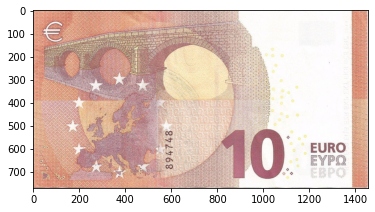

In [19]:
MARKER_NAME = "ten_euro_sample.png"
marker_img = io.imread(os.path.join(MARKER_FOLDER, MARKER_NAME))
imshow(marker_img)

In [20]:
metadata_df.query('type == "TenEUR"').index

Int64Index([ 1,  3,  7, 11, 13, 14, 16, 19, 20, 22, 26, 29, 34, 41, 44, 47, 49,
            50, 57, 58, 59, 60, 61, 62, 63, 66, 76],
           dtype='int64')

20191219_110613.jpg


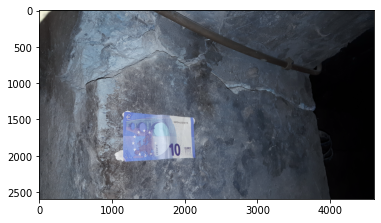

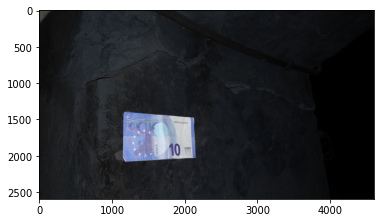

In [23]:
# Load Image # GE: 11, 22 BE: 3, 20
IMG_INDEX = 22 # Select Image ID from metadata
raw_img = get_img(metadata_df, IMG_INDEX, engine='cv') # Open Image
raw_polygon = eval(metadata_df.loc[IMG_INDEX].polygon) # Load Ground Truth Polygon
raw_bndbox = eval(metadata_df.loc[IMG_INDEX].bnd_box) # Load Ground Truth Bounding Box
gt_mask = polygon_to_mask(raw_img.shape[1], raw_img.shape[0] , raw_polygon) # Generate Ground Truth Mask
imshow(raw_img)
imshow_masked(raw_img,gt_mask)

## Marker detection

### SIFT Detector

As described for the Aruco Detection, we proceed to a SIFT detection first by detecting the features of interest in the `trainImg`

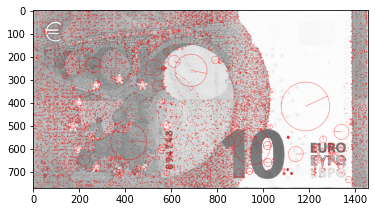

In [25]:
MIN_MATCH_COUNT=30
FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})


sift_detector=cv2.xfeatures2d.SIFT_create()
sift_trainImg=cv2.imread(os.path.join(MARKER_FOLDER, MARKER_NAME),0)
sift_trainKP,sift_trainDesc=sift_detector.detectAndCompute(sift_trainImg,None)
sift_trainImg1=cv2.drawKeypoints(sift_trainImg,sift_trainKP,None,(255,0,0),4)
plt.imshow(sift_trainImg1)
plt.show()

Then we try to found as many matches/corresponding features as possible

In [26]:
sift_QueryImgBGR = cv2.imread(os.path.join(IMG_FOLDER, metadata_df.loc[IMG_INDEX].file))
sift_QueryImg=cv2.cvtColor(sift_QueryImgBGR,cv2.COLOR_BGR2GRAY)
sift_queryKP,sift_queryDesc=sift_detector.detectAndCompute(sift_QueryImg,None)
sift_matches=flann.knnMatch(sift_queryDesc,sift_trainDesc,k=2)
sift_goodMatch=[]
for m,n in sift_matches:
    if(m.distance<0.75*n.distance):
        sift_goodMatch.append(m)
len(sift_goodMatch)

274

In [27]:
sift_borders = drawer_detector(
    QueryImgBGR=sift_QueryImgBGR,
    trainImg=sift_trainImg,
    goodMatch=sift_goodMatch,
    trainKP=sift_trainKP,
    queryKP=sift_queryKP,
    force_true=True
)

Match Found


In [28]:
if sift_borders is not None:
    sift_trainBorder, sift_queryBorder = sift_borders

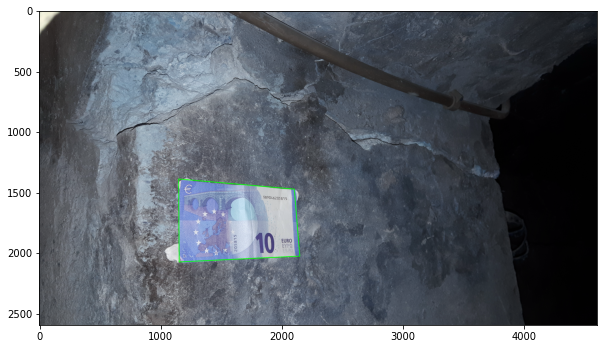

In [29]:
imshow(sift_QueryImgBGR, (10, 10))

GENERATED MASK


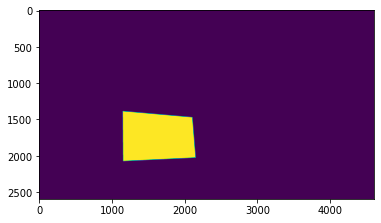

GROUND TRUTH MASK


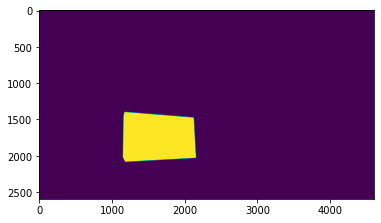

In [30]:
pred_mask = polygon_to_mask(sift_QueryImgBGR.shape[1], sift_QueryImgBGR.shape[0], sift_queryBorder)
print("GENERATED MASK")
imshow(pred_mask)
print("GROUND TRUTH MASK")
imshow(gt_mask)

In [31]:
I = pred_mask * gt_mask
U = (pred_mask + gt_mask).clip(max=1)
IoU = I.sum() / U.sum()
print(f"IoU = {IoU*100}%")

IoU = 96.34494279279716%


The SIFT detection provides a great accuracy in the case of a predominant bank note in the scene. It tends to provides unreliable borders when the markers is small compare to the size of the scene.

### SURF Detector

SURF detection works similarly as SIFT detection excepts for the feature detection. SURF provides weaker features in larger number to rely on the strength in number.

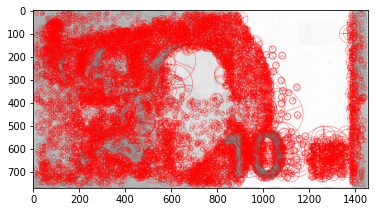

In [32]:
MIN_MATCH_COUNT=30
FLANN_INDEX_KDITREE=0
flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
flann=cv2.FlannBasedMatcher(flannParam,{})


surf_detector=cv2.xfeatures2d.SURF_create(300)
surf_trainImg=cv2.imread(os.path.join(MARKER_FOLDER, MARKER_NAME),0)
surf_trainKP,surf_trainDesc=surf_detector.detectAndCompute(surf_trainImg,None)
surf_trainImg1=cv2.drawKeypoints(surf_trainImg,surf_trainKP,None,(255,0,0),4)
plt.imshow(surf_trainImg1)
plt.show()

In [33]:
surf_QueryImgBGR = cv2.imread(os.path.join(IMG_FOLDER, metadata_df.loc[IMG_INDEX].file))
surf_QueryImg=cv2.cvtColor(surf_QueryImgBGR,cv2.COLOR_BGR2GRAY)
surf_queryKP,surf_queryDesc=surf_detector.detectAndCompute(surf_QueryImg,None)
surf_matches=flann.knnMatch(surf_queryDesc,surf_trainDesc,k=2)
surf_goodMatch=[]
for e in surf_matches:
    if isinstance(e, list) and len(e) == 2:
        m, n = e
        if(m.distance<0.75*n.distance):
            surf_goodMatch.append(m)
len(surf_matches), len(surf_goodMatch)

(30268, 231)

In [34]:
surf_borders = drawer_detector(
    QueryImgBGR=surf_QueryImgBGR,
    trainImg=surf_trainImg,
    goodMatch=surf_goodMatch,
    trainKP=surf_trainKP,
    queryKP=surf_queryKP,
)
if surf_borders is not None:
    surf_trainBorder, surf_queryBorder = surf_borders

Match Found


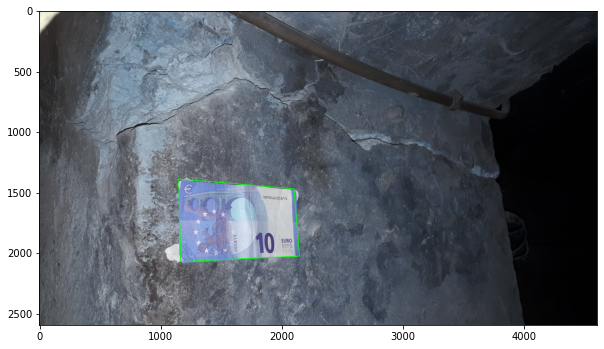

In [35]:
imshow(surf_QueryImgBGR, (10, 10))

GENERATED MASK


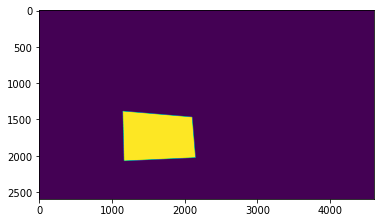

GROUND TRUTH MASK


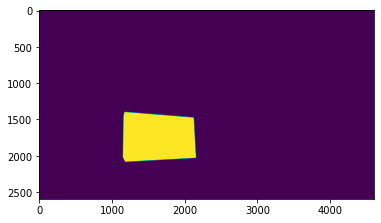

IoU = 95.5088958998694%


In [36]:
pred_mask = polygon_to_mask(surf_QueryImgBGR.shape[1], surf_QueryImgBGR.shape[0], surf_queryBorder)
print("GENERATED MASK")
imshow(pred_mask)
print("GROUND TRUTH MASK")
imshow(gt_mask)
I = pred_mask * gt_mask
U = (pred_mask + gt_mask).clip(max=1)
IoU = I.sum() / U.sum()
print(f"IoU = {IoU*100}%")

As described for SIFT, SURF detection has a great accuracy over large bank notes present in the scene. In case of smaller samples, the detection is even worse than for SIFT since the detected features are weaker.

## Warp

When we obtain the bank notes corners, we can proceed to the warping, with the exact samle methodology proposed for Aruco detection. By ordering the bank note corners with `order_points` we are able to determine which line is the horizontal one and which one is the vertical one.

In [32]:
corners = sift_queryBorder
corners_ordered = order_points(corners[0])
corners_ordered

array([[1153.4716, 1386.3184],
       [2108.1602, 1470.7106],
       [2153.2646, 2023.1182],
       [1157.374 , 2071.04  ]], dtype=float32)

In [33]:
horizontal_lines = [
    [corners_ordered[0], corners_ordered[1]],
    [corners_ordered[3], corners_ordered[2]],
]
vertical_lines = [
    [corners_ordered[3], corners_ordered[0]],
    [corners_ordered[2], corners_ordered[1]],
]
vertical_edgelets = vector_representation(vertical_lines)
horizontal_edgelets = vector_representation(horizontal_lines)
vertical_hlines = to_homogenous_geometry(*vertical_edgelets)
horizontal_hlines = to_homogenous_geometry(*horizontal_edgelets)
vp_vert = np.cross(vertical_hlines[0], vertical_hlines[1])
vp_hor = np.cross(horizontal_hlines[0], horizontal_hlines[1])

For a strong perspective the output image shape may be very huge and therefore cause a high computation time. Since we have detected the corners, the detection is still possible and will be done properly at the cost of time.

In [34]:
(
    sift_QueryImgBGR.shape,
    infer_warp_shape(sift_QueryImgBGR, vp_vert, vp_hor),
    infer_warp_shape(sift_QueryImgBGR, vp_vert, vp_hor, clip=True, clip_factor=4)
)

((2592, 4608, 3), (30234, 12138), (9216, 12138))

In [35]:
sift_image_result = warp_image(sift_QueryImgBGR, vp_vert, vp_hor, clip_factor=4)

As we see, the perspective reprojection is done correctly. The horizontal and vertical lines are aligned properly.

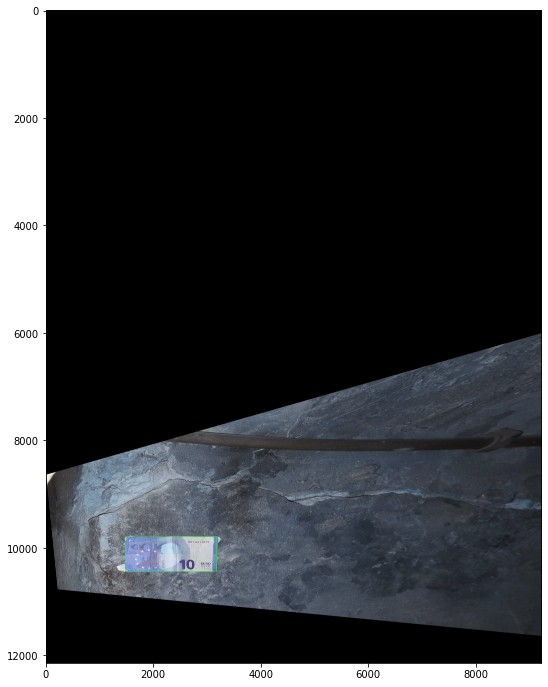

In [37]:
imshow(sift_image_result, figsize=(12,12))

# Next steps

Relying on features detector is an easy entry way. But it does not scale easily for scene with small bank notes which are not edge cases, but might be encountered frequently.

We can propose a user based approach by incentivising the user to draw the region of interest in the front-end
- The user may give the exact four corners in the image for a precise and quick detection
- Or it might indicate the area of interest to let our algorithm to deep dive into this area

Another and less hypothetical solution would involve deep learning. Fast learner CNN exists for this specific segmentation task. Those algorithm, running on GPU/CPU but trained on GPU can provides quick and accurate location and class. Many implementation exists with pre-trained weights to fine tune via transfer learning (to save training time). Such algorithm you can dig up into are:
- [YOLO](https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/): Fastest algorithm so far for object detection
- [Mask RCNN](https://github.com/matterport/Mask_RCNN): Way slower than YOLO but gives better accuracy on object detection tasks

Since you have implemented those algorithm, you'll be able to post process the detected area to obtain the most accurate mask of the bank note possible. By using the current warping methodology or by implementing another one you could solve the bank note perspective correction.